In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta

In [3]:
class DataAction:
  """
  The nuclear data-processing method.
  
  """

  def __init__(self):
    self.imp = None
    self.df = None
    self.chunk_size = 10000
    self.dfList = []
    self.night_evening_t = '20:00:00'
    self.night_morning_t = '06:00:00'
    self.night_mw = None


  def data_imp(self, file_name):
    # import from data location
    folder_path = '..\\data\\'
    file_path = folder_path + file_name
    self.imp = pd.read_csv(file_path, low_memory = False)


  def data_filter(self, df, keep_cols):
    # Process df inplace
    col_names = df.columns.tolist()
    for col in keep_cols:
        col_names.remove(col)
    df.drop(columns=col_names, inplace = True)
    df.dropna(inplace=True)
    df.rename(columns = {'cet_cest_timestamp':'date_time'}, inplace = True)
    self.df = df.set_index('date_time')


  def df_split(self, chunk_size):
    # splits the dataframe into smaller dataframes
    for i in range(0, self.df.shape[0], chunk_size):
        self.dfList.append(self.df[i:i+chunk_size])
    print('Number of data frame segments = ', len(self.dfList))


  def imp_procc(self, file_name, keep_cols):
    # easy import, data filter and split
    self.data_imp(file_name)
    self.data_filter(self.imp, keep_cols)
    self.df_split(self.chunk_size)
    print("dfList created successfully.")


  def parse_procc(self, df):
    # parse dates and convert index to time series
    # take the row difference and drop first NaN
    df.index = pd.to_datetime(df.index, exact=True, cache=True, format='%Y-%m-%d %H:%M:%S', dayfirst=True)
    ts = df.diff()
    ts.drop(str(ts.index[0]), inplace=True) # drop first NaN row
    return ts


  def unique_date(self, df): # helper function
    # find unique days in the time-series index df
    return df.index.map(lambda t: str(t.date())).unique().tolist()


  def get_night(self, ts, evening_date, start_time, end_time):
    # get the dates for loc slice
    start = evening_date + ' ' + start_time
    foo = pd.to_datetime(evening_date)
    bar = foo.replace(hour=int(end_time[0:2]), minute=int(end_time[3:5]), second=int(end_time[6:8])).strftime('%H:%M:%S')
    end = str(foo + timedelta(days=1))[:11] + bar

    # check for available date
    dates = self.unique_date(ts)
    if evening_date in dates:
        # print("Date is accepted.")
        return ts.loc[start : end]
    else:
        print("Error: Evening_date is not part of the selected dataset!")


  def time_wind(self, ts, wind_length):
    # select random night time window of length wind_length
    length = len(ts.index) - wind_length
    time_0 = np.random.randint(0,length)
    foo = night_mw.index[time_0]

    start = foo.strftime('%Y-%m-%d %H:%M:%S')
    bar = foo + timedelta(minutes=wind_length)
    end = bar.strftime('%Y-%m-%d %H:%M:%S')

    print("Start time: ", start)
    print("End time: ", end)
    
    return start, end


  def sgen_write(self, ts, start, end, col_name, val):
    # write sgen val to df on col in time window
    ts.loc[start : end, col_name] = val
    return ts


  def power_merge(self):
    """
    Randomly select two days and merge them into a single df

    """

    while True:
      try:
          # pick two random TimeSeries
          df_rand = np.random.choice(len(da.dfList), 2, replace=False)
          ts1 = da.parse_procc(da.dfList[df_rand[0]])
          ts2 = da.parse_procc(da.dfList[df_rand[1]])

          # test that they are the same size then merge
          if ts1.size == ts2.size:            
              # limit TS to night window
              night1 = da.get_night(ts1, da.unique_date(ts1)[0], da.night_evening_t, da.night_morning_t).copy()
              night2 = da.get_night(ts2, da.unique_date(ts2)[0], da.night_evening_t, da.night_morning_t).copy()
              night2.index = night1.index # use the first index for both, since only the time matters

              # rename cols
              names1 = {'DE_KN_residential1_grid_import': 'load_1',
                      'DE_KN_residential2_grid_import': 'load_2'}
              night1.rename(columns = names1, inplace=True)
              names2 = {'DE_KN_residential1_grid_import': 'load_3',
                      'DE_KN_residential2_grid_import': 'load_4'}
              night2.rename(columns = names2, inplace=True)

              # convert units to W (avg value over a minute)
              factor = 1000*60
              night1 = night1*factor
              night2 = night2*factor
              night_merge = night1.join(night2)
              
              return night_merge

      except:
          print("Whoops, grabbing a different touple of dates...")
  

In [4]:
da = DataAction()
keep_cols = ['DE_KN_residential1_grid_import',
             'DE_KN_residential2_grid_import',
             'cet_cest_timestamp']
da.imp_procc("house_data.csv", keep_cols)

Number of data frame segments =  90
dfList created successfully.


Whoops, grabbing a different touple of dates...


<AxesSubplot:xlabel='date_time'>

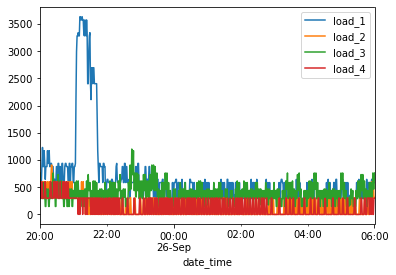

In [5]:
night_merge = da.power_merge()
night_merge.plot()

In [14]:
# create mw night dataset copy
night_mw = night_merge.copy()/1000000

# create sgen columns
night_mw.insert(1, 'sgen_1', 0)
night_mw.insert(3, 'sgen_2', 0)
night_mw.insert(5, 'sgen_3', 0)
night_mw.insert(7, 'sgen_4', 0)
night_mw.head()

,load_1,sgen_1,load_2,sgen_2,load_3,sgen_3,load_4,sgen_4
date_time,,,,,,,,
2016-09-25 20:00:00+02:00,0.000586,0,0.000293,0,0.000762,0,0.000601,0
2016-09-25 20:01:00+02:00,0.000586,0,0.000601,0,0.000293,0,0.000601,0
2016-09-25 20:02:00+02:00,0.000586,0,0.000601,0,0.000293,0,0.000300,0
2016-09-25 20:03:00+02:00,0.000586,0,0.000601,0,0.000586,0,0.000300,0
2016-09-25 20:04:00+02:00,0.000937,0,0.000308,0,0.000293,0,0.000601,0


In [15]:
"""
Write sgen vals over random time window for cols

"""
sgens = ['sgen_1','sgen_2','sgen_3','sgen_4']
sgen_val = 0.01 # 0.010 or 10kW is typical high-end

for i in sgens:
    # writes directly to night_mw
    start, end = da.time_wind(night_mw, 60)
    da.sgen_write(night_mw, start, end, i, sgen_val) 


Start time:  2016-09-26 03:21:00
End time:  2016-09-26 04:21:00
Start time:  2016-09-26 04:06:00
End time:  2016-09-26 05:06:00
Start time:  2016-09-26 00:55:00
End time:  2016-09-26 01:55:00
Start time:  2016-09-25 22:08:00
End time:  2016-09-25 23:08:00


### Simulation Cases

#### For all scenarios:
- Number of sgens can vary from 1 to max
- Charging time window (of 1hr?) can vary between _20:00_ and _6:00_
- Number of coordinating house owners can vary from 0 to all

        - Parties don't charge EVs at the same time; assume "one after another" approach
        - Neigboring parties can reduce local load. Distant partners reduce overall load
    
Critical case: max number of EVs, all charging at the same time. (Load profiles still vary)


#### Evaluation criteria and metrics
- Max line load
- Line overload


### Simulation Process

1. Randomly select load profile for a single day
2. Limit the profile to night window
3. Create a generator column (sgen)
4. Select a time window. Assign power value to the sgen column
5. Repeat steps 1-4 for desired number of loads/sgens in the network
6. Use resultant dataframe for power evaluation

Repeat for different case scenarios

In [16]:
import os

import pandapower as pp
import pandapower.networks as pn
import pandapower.plotting as plot
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl

In [17]:
net = pn.four_loads_with_branches_out()

pp.create_sgen(net, 6, p_mw=0, name='sgen_1', q_mvar=0)
pp.create_sgen(net, 7, p_mw=0, name='sgen_2', q_mvar=0)
pp.create_sgen(net, 8, p_mw=0, name='sgen_3', q_mvar=0)
pp.create_sgen(net, 9, p_mw=0, name='sgen_4', q_mvar=0)

net.load.name.at[0] = "load_1"
net.load.name.at[1] = "load_2"
net.load.name.at[2] = "load_3"
net.load.name.at[3] = "load_4"

# pp.runpp(net)
net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,load_1,6,0.03,0.01,0.0,0.0,NaN,1.0,True,wye
1,load_2,7,0.03,0.01,0.0,0.0,NaN,1.0,True,wye
2,load_3,8,0.03,0.01,0.0,0.0,NaN,1.0,True,wye
3,load_4,9,0.03,0.01,0.0,0.0,NaN,1.0,True,wye


In [18]:
# test_set = night_mw.iloc[:10,:].copy()
test_set = night_mw.copy()
test_set.index = range(0, test_set.shape[0])
# test_set.insert(0, "timestep", range(0,test_set.shape[0]))
ds = DFData(test_set)
test_set

,load_1,sgen_1,load_2,sgen_2,load_3,sgen_3,load_4,sgen_4
0,0.000586,0.0,0.000293,0.0,0.000762,0.0,0.000601,0.0
1,0.000586,0.0,0.000601,0.0,0.000293,0.0,0.000601,0.0
2,0.000586,0.0,0.000601,0.0,0.000293,0.0,0.000300,0.0
3,0.000586,0.0,0.000601,0.0,0.000586,0.0,0.000300,0.0
4,0.000937,0.0,0.000308,0.0,0.000293,0.0,0.000601,0.0
...,...,...,...,...,...,...,...,...
596,0.000645,0.0,0.000293,0.0,0.000293,0.0,0.000300,0.0
597,0.000586,0.0,0.000308,0.0,0.000762,0.0,0.000000,0.0
598,0.000586,0.0,0.000601,0.0,0.000469,0.0,0.000000,0.0
599,0.000586,0.0,0.000293,0.0,0.000469,0.0,0.000300,0.0


In [19]:
ConstControl(net, element="sgen", variable="p_mw", element_index=net.sgen.index,
             profile_name=["sgen_1","sgen_2","sgen_3","sgen_4"], data_source=ds)
ConstControl(net, element="load", variable="p_mw", element_index=net.load.index,
             profile_name=["load_1","load_2","load_3","load_4"], data_source=ds)

net.controller

,object,in_service,order,level,initial_run,recycle
0,ConstControl [sgen.p_mw],True,-1.0,-1,False,"{'trafo': False, 'gen': False, 'bus_pq': True}"
1,ConstControl [load.p_mw],True,-1.0,-1,False,"{'trafo': False, 'gen': False, 'bus_pq': True}"


In [20]:
path = '..\\results\\'
ow = OutputWriter(net, time_steps=range(0,test_set.shape[0]),output_path=path, output_file_type=".xlsx")
ow.log_variable('res_load', 'p_mw')
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_line', 'loading_percent')
ow.log_variable('res_line', 'i_ka')

run_timeseries(net, time_steps=range(0,test_set.shape[0]))

100%|██████████| 601/601 [00:03<00:00, 196.66it/s]


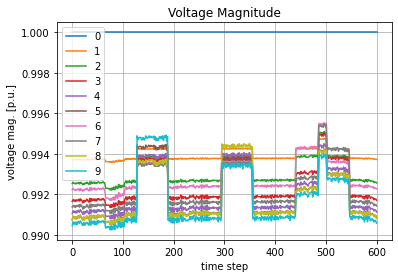

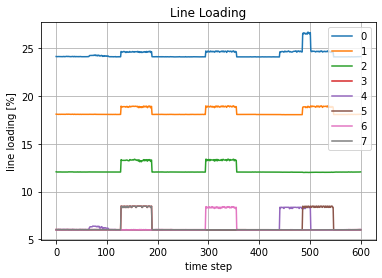

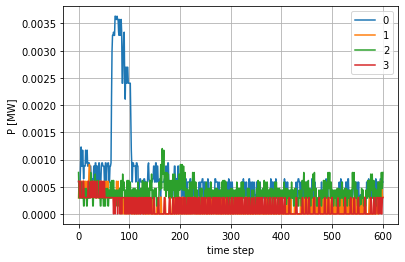

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(path, "res_bus", "vm_pu.xlsx")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(path, "res_line", "loading_percent.xlsx")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(path, "res_load", "p_mw.xlsx")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()